# CONFIGURATION:

In [61]:
from jaad_data import JAAD
import torch
from PIL import Image
from torchvision import transforms
from torchvision import models
import matplotlib.pyplot as plt
import network
import openpose
from openpose import model
from openpose import util
from openpose.body import Body
import copy

import pickle
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import torch.nn.functional as F

In [62]:
JAAD_PATH = '../JAAD'
DEEPLAB_PATH = '../best_deeplabv3plus_resnet101_cityscapes_os16.pth'
SUBSET_PATH = '../subset'
FILENAME_SUB = '../masks_results_sub.pkl'
FILENAME_BIG = '../masks_results_big.pkl'
POSE_PATH = '../body_pose_model.pth'   


In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.cuda.empty_cache()

cuda


In [64]:
RUN =True

# DATASET

In [ ]:
# stampa una sequenza di informazioni del dataset

#jaad_dt.generate_database() # in particolare, questo stampa un sacco di informazioni come borse vestiti semafori ecc
#jaad_dt.get_data_stats() # mentre questo stampa informazioni sui numeri di frame, video, pedoni, bbox ecc
#print('Train sequences:', len(seq_train['image'][0][0]))  # stampa la lunghezza della sequenza di training selezionata

In [65]:
# Load the JAAD dataset
jaad_dt = JAAD(data_path=SUBSET_PATH)


data_opts = {
    'fstride': 10,
    'sample_type': 'beh'
}

seq_train = jaad_dt.generate_data_trajectory_sequence('train', **data_opts)  
seq_test = jaad_dt.generate_data_trajectory_sequence('test', **data_opts)  

---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen_data': False}
kfold_params: {'num_folds': 5, 'fold': 1}
---------------------------------------------------------
Generating database for jaad
jaad database loaded from c:\Users\Filippo\Documents\VSCode\Pedestrian_Intention\subset\data_cache\jaad_database.pkl
---------------------------------------------------------
Generating intention data
Split: train
Number of pedestrians: 4 
Total number of samples: 2 
---------------------------------------------------------
Generating action sequence data
fstride: 10
sample_type: beh
subset: default
height_rng: [0, inf]
squarify_ratio: 0
data_split_type: default
seq_type: intention
min_track_size: 15
random_params: {'ratios': None, 'val_data': True, 'regen

In [66]:
#trasformazioni che vengono usate dentro global context
train_transforms = transforms.Compose([
    transforms.Resize((512, 512)),  # Ridimensiona le immagini a 512x512
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [67]:
# Trasformazioni per le immaginin che vengono usate nel local context e nel pose extractor
transform_lc = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# GLOBAL CONTEXT EXTRACTION:

In [68]:
if RUN:
    deeplab_model = network.modeling.__dict__['deeplabv3plus_resnet101'](num_classes=19)
    deeplab_model.load_state_dict(torch.load(DEEPLAB_PATH)['model_state'])
    deeplab_model.to(device)
    deeplab_model.eval()

In [69]:
GC_trans = transforms.Compose([
    transforms.Resize((224, 224)),  # Ridimensiona le immagini a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [70]:
def get_segmentation_mask(image_path, model, preprocess):
    """ funzione che prende in input le path delle imagini, il modello e la funzione di preprocessamento 
    e restituisce la maschera segmentata dell'immagine resizata a 224x224"""
    
    # Load the image
    input_image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)  # Create a batch with a single image
    
    # Pass the image through the model
    with torch.no_grad():
        output = model(input_batch)
        
    # Check if output is a tensor or a dictionary
    if isinstance(output, dict):
        output = output['out'][0]
    elif isinstance(output, torch.Tensor):
        output = output[0]
    else:
        raise ValueError(f"Unexpected output type: {type(output)}")
    
    # Convert the output to a mask
    output_predictions = output.argmax(0)
    
    # Aggiungi una dimensione batch e canale alla maschera per il ridimensionamento
    output_predictions = output_predictions.unsqueeze(0).unsqueeze(0).float()
    print(output_predictions.shape)
    tr = transforms.ToPILImage()
    pic = tr(output_predictions.squeeze(1))
    pic= pic.convert("RGB")
    resized_mask = GC_trans(pic)

    # Ridimensiona la maschera a 224x224
    #resized_mask = F.interpolate(output_predictions, size=(224, 224), mode='nearest')

    # Rimuovi le dimensioni batch e canale
    #resized_mask = resized_mask.squeeze(1).long().cpu()
    
    plt.imshow(resized_mask)
    # resized_maskk = tr(resized_mask)
    # plt.imshow(resized_maskk)
    # plt.show()
    return resized_mask

In [71]:
def process_video_frames(seq_train, model, preprocess):
    # """funzione che prende in input la sequenza di training, il modello e la funzione di preprocessamento, restituisce una
    # lista di segmentation mask per ogni frame di ogni video della sequenza di training"""
    all_masks = []
    for video_frames in seq_train['image']:
        video_masks = []

        for frame_path in video_frames:
            mask = get_segmentation_mask(frame_path, model, preprocess)
            #visualize_mask(frame_path, mask)
            video_masks.append(mask)
        all_masks.append(video_masks)
    return all_masks

In [ ]:
# # Visualizza la maschera semantica
# def visualize_mask(image_path, mask):
#     image = Image.open(image_path).convert("RGB")
#     image = image.resize((256, 256))  # Ridimensiona per la visualizzazione
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.title("Original Image")
#     plt.subplot(1, 2, 2)
#     plt.imshow(mask, cmap='jet')
#     plt.title("Semantic Mask")
#     plt.show() 


torch.Size([1, 1, 512, 512])


TypeError: Invalid shape (3, 224, 224) for image data

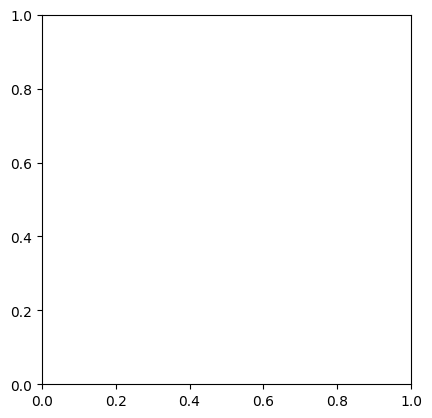

In [73]:
if RUN:
    all_video_masks = process_video_frames(seq_train, deeplab_model, train_transforms)
    seq_train['masks'] = all_video_masks
    # Apri il file in modalità scrittura binaria e salva il dizionario
    with open(FILENAME_BIG, 'wb') as f:
        pickle.dump(seq_train['masks'], f)
else:
    #recover data:
    with open(FILENAME_BIG, 'rb') as f:
        seq_train['masks'] = pickle.load(f)

    # Verifica che i risultati siano stati caricati correttamente
    print(seq_train['masks'])

# LOCAL CONTEXT:

In [ ]:
# funzione che croppa i frames sul bounding boxes
def crop_image(img, bbox):
    x1, y1, x2, y2 = bbox
    return img.crop((x1, y1, x2, y2))

In [ ]:
all_images = []
for i in range(seq_train['image'].__len__()):
    aux_list = []
    for j in range(seq_train['image'][i].__len__()):
        #open the images from the paths 
        img_path = seq_train['image'][i][j]
        img = Image.open(img_path).convert("RGB")
        bbox = seq_train['bbox'][i][j]
        #compute local context cropping images arroun the bboxes
        cropped_images = crop_image(img, bbox) 
        aux_list.append(cropped_images)
    all_images.append(aux_list)
print(type(all_images))
print(all_images[0][0])
plt.figure(figsize=(8, 8))
plt.imshow(all_images[0][0])
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()


# POSE KEYPOINTS: 

In [ ]:
body_estimation = Body('../body_pose_model.pth')
test_image = 'pic2.png'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset = body_estimation(oriImg)
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

In [ ]:
def extract_pose_sequence(frames,body_model):
    """funzione che prende in input i frames e il modello di openpose e restituisce una lista di tensori di pose 
    per ciascuna persona nel tempo"""
    pose_sequences = []  # Lista di pose per ciascuna persona nel tempo
    for frame in frames:
        candidate, subset = body_model(frame)
        frame_poses = []
        for person in subset:
            if person[-1] >= 4:  # Almeno 4 punti chiave rilevati
                pose = []
                for i in range(18):
                    if person[i] != -1:
                        x, y = candidate[int(person[i])][:2]
                    else:
                        x, y = -1, -1  # Punti chiave mancanti
                    pose.extend([x, y])
                frame_poses.append(pose)
        
        pose_sequences.append(frame_poses)

    # Trasponi la lista di liste per ottenere le sequenze temporali per ciascuna persona
    # Cioè da [[pose_frame1_person1, pose_frame1_person2, ...], [pose_frame2_person1, pose_frame2_person2, ...], ...]
    # a [[pose_frame1_person1, pose_frame2_person1, ...], [pose_frame1_person2, pose_frame2_person2, ...], ...]
    person_pose_sequences = list(map(list, zip(*pose_sequences)))

    person_pose_sequences = [torch.tensor(person_poses, dtype=torch.float32) for person_poses in person_pose_sequences]
    return person_pose_sequences


In [ ]:
# Caricamento del modello
body_model = Body(POSE_PATH)

# Caricamento dei frame (qui puoi sostituire con il tuo metodo di caricamento dei frame)
all_poses =[]
    
for pics in all_images:
    list_aux =[]
# Estrazione delle pose
    for pic in pics:
        img_np = np.array(pic)

# Converti i canali di colore da RGB a BGR se necessario
        img_cv2 = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        list_aux.append(img_cv2)
    pose_sequences = extract_pose_sequence(list_aux, body_model)
    print("len pose seq",len(pose_sequences))
    print("pose seq:",pose_sequences)
    all_poses.append(pose_sequences)
print("LEN ALL POSES:", len(all_poses))
seq_train['poses'] = all_poses

In [ ]:

plt.imshow(canvas[:, :, [2, 1, 0]])
plt.axis('off')
plt.show()

# MODEL:

In [ ]:
class VisionBranchLocal(torch.nn.Module):
    """definizione del modello per il local context, prende in input le immagini croppate e restituisce un tensore,
    le immagini croppate vengono fatte passare dentro una VGG16, una GRU e un attention block"""
    
    def __init__(self, vgg16):
        super(VisionBranchLocal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, cropped_images):
        seq_len, c, h, w = cropped_images.size()
        
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            

            img = cropped_images[i]            
            vgg_feat_img = self.vgg16.features(img)
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        print("SIZE1:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE1:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE1:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE1:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [ ]:
class VisionBranchGlobal(torch.nn.Module):
    """definizione del modello per il global context, prende in input le maskere semantiche e restituisce un tensore,
    le maskere semantiche vengono fatte passare dentro una VGG16, una GRU e un attention block"""

    def __init__(self, vgg16):
        super(VisionBranchGlobal, self).__init__()
        self.vgg16 = vgg16
        self.avgpool = torch.nn.AvgPool2d(kernel_size=14)  # Pooling layer con kernel 14x14
        self.gru = torch.nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, masks):
        seq_len = masks.size()[0]
        print("size forward:",seq_len)
        # Estrai feature dalle immagini con VGG19
        vgg_features = []
        for i in range(seq_len):            
            img = masks[i]            
            vgg_feat_img = self.vgg16.features(img)
            print("passa")
            pooled_feat_img = self.avgpool(vgg_feat_img)  # Applica il pooling
            vgg_feat_img = pooled_feat_img.view(pooled_feat_img.size(0), -1)  # Flatten features
            vgg_features.append(vgg_feat_img)
        
        vgg_features = torch.stack(vgg_features, dim=1).permute(2,1,0)

        print("SIZE2:",vgg_features.shape)
        gru_out, _ = self.gru(vgg_features)
        print("SIZE2:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE2:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE2:",context_vector.shape)
        out = self.tanh((context_vector))
        return out


In [ ]:
class NVisionBranch(torch.nn.Module):
    """classe relativa al non-vision brach, prende in input le pose e le bbox in formato tensore, esse vengono fatte passare
    dentro una GRU e un attention block, l'ordine influenza la prestazioni"""
    
    def __init__(self):
        super(NVisionBranch, self).__init__()
        self.gru = torch.nn.GRU(input_size=36, hidden_size=256, num_layers=2, batch_first=True)
        self.gru2 = torch.nn.GRU(input_size=256+4, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(256, 2)  # Output: crossing or not crossing
        self.attn = torch.nn.Linear(256, 1)  # Attention layer
        self.tanh = torch.nn.Tanh()

    def forward(self, pose,bbox):
        gru_out, _ = self.gru(pose)
        print("SIZE:",gru_out.shape)
        LP = torch.cat(gru_out,bbox)
        gru_out, _ = self.gru2(LP)
        print("SIZE:",gru_out.shape)
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)
        print("SIZE:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * gru_out, dim=1)
        print("SIZE:",context_vector.shape)
        #out = self.sigmoid(self.fc(gru_out[:, -1, :]))   
        out = self.tanh((context_vector))
        return out


In [ ]:
class PedestrianIntentModel(torch.nn.Module):
    """definizione del modello finale, prende in input gli output del vision brach e del non vision branch, viene fatta
    una concatenazione che in seguito passa dentro un attention e un fully connected layer, l'output è la predizione,
    (passa non passa)"""

    def __init__(self, vision_branch_local,vision_branch_global,non_vision_branch):
        super(PedestrianIntentModel, self).__init__()
        self.vision_branch_local = vision_branch_local
        self.vision_branch_global = vision_branch_global
        self.non_vision_branch = non_vision_branch
        self.fc = torch.nn.Linear(256, 2) # Output: crossing or not crossing
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, cropped_images, bboxes,masks,poses):
        vision_out_local = self.vision_branch_local(cropped_images)
        vision_out_global = self.vision_branch_global(masks)
        non_vision_out = self.non_vision_branch(poses,bboxes)

        vision_out = torch.cat((vision_out_local, vision_out_global), dim=-1)
        final_fusion = torch.cat((vision_out, non_vision_out), dim=-1)

        attn_weights = torch.softmax(self.attn(final_fusion), dim=1)
        print("SIZE tot:",attn_weights.shape) 
        context_vector = torch.sum(attn_weights * final_fusion, dim=1)

        out = self.sigmoid(self.fc(context_vector))
        return out

In [ ]:
class VGG16_FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(VGG16_FeatureExtractor, self).__init__()
        self.features = torch.nn.Sequential(*list(vgg16.features.children())[:24]) # block4_pool è il 23° livello
    
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
# Carica il modello VGG19 pre-addestrato
vgg16 = models.vgg16(pretrained=True)

#cut the model at the 24th layer:
vgg16_fe = VGG16_FeatureExtractor()
vgg16_fe


# define the models of the branches
model_local = VisionBranchLocal(vgg16_fe).to(device)
model_global = VisionBranchGlobal(vgg16_fe).to(device)
model_non_vision = NVisionBranch().to(device)
model = PedestrianIntentModel(model_local,model_global,model_non_vision).to(device)


# DATASET & DATALOADER

In [ ]:
class JAADDataset(Dataset):
    """definizione della classe per il custom dataset, prende in input la seq_train, le immagini e le trasformazioni,
    restituisce le immagini croppate le bboxes, le maschere, le pose e la lable"""

    def __init__(self, seq_data, all_images, transform=None):
        self.seq_data = seq_data
        self.all_images = all_images
        self.transform = transform

    def __len__(self):
        return len(self.seq_data['image'])

    def __getitem__(self, idx):
        # Carica le immagini e le maschere
        #get path of images
        #img_paths = self.seq_data['image'][idx]
        #get bboxes 
        bbox_sequence = self.seq_data['bbox'][idx]
        masks = self.seq_data['masks'][idx]
        poses = self.seq_data['poses'][idx]
        all_images = self.all_images[idx]
        #open the images from the paths 
        #images = [Image.open(img_path).convert("RGB") for img_path in img_paths]

        #compute local context cropping images arroun the bboxes
        #cropped_images = [crop_image(img, bbox) for img, bbox in zip(images, bbox_sequence)]

        #mask_paths = self.seq_data['masks'][idx]

        #masks = [Image.fromarray(mask.numpy()) for mask in mask_paths]
        if self.transform:
            #images = [self.transform(img) for img in images]
            cropped_images = [self.transform(img) for img in all_images]
            #
            #masks = [mask.Resize(224, 224) for mask in masks]

        bboxes = torch.tensor(self.seq_data['bbox'][idx], dtype=torch.float32)
        intents = torch.tensor(self.seq_data['intent'][idx], dtype=torch.long)
        return  cropped_images, bboxes, masks, poses, intents

In [ ]:
train_dataset = JAADDataset(seq_train,all_images=all_images, transform=transform_lc)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# TRAINING:

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def show_pic(image):    
    numpy_data = image.cpu().numpy()

    # Create a new figure
    plt.figure(figsize=(8, 8))

    # Display the image
    plt.imshow(numpy_data)  # Use 'gray' colormap for grayscale images

    # Remove axes ticks
    plt.axis('off')

    # Add a title if needed
    plt.title("Your Image Title")

    # Show the plot
    plt.show()

In [ ]:
print(train_dataset.__getitem__(0))
print(len(train_dataset))
print(train_dataset.__getitem__(0)[1][0])
denormalized_tensor = denormalize(train_dataset.__getitem__(0)[0][0].clone(), mean, std)
if denormalized_tensor.dim() == 3:
    img_np = denormalized_tensor.permute(1, 2, 0).cpu().numpy()
elif denormalized_tensor.dim() == 4:
    img_np = denormalized_tensor[0].permute(1, 2, 0).cpu().numpy()

# Clip values to [0, 1] range
img_np = np.clip(img_np, 0, 1)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(img_np)
plt.axis('off')
plt.title("Original (Denormalized) Image")
plt.show()
show_pic(train_dataset.__getitem__(0)[0][0].permute(1,2,0))


In [ ]:
num_epochs = 10
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    for cropped_images, bboxes, masks, poses, intents in train_loader:
        print("TRAINING:")
        print("shape0",len(cropped_images))
        cropped_images = torch.stack(cropped_images, dim=1).squeeze(0).permute(0, 1, 2,3).to(device)  # Converte la lista di immagini in un tensor
        print("shape",cropped_images.shape,masks[0].shape, len(masks))
        masks = torch.stack(masks,dim=1).squeeze(0).float().to(device)  # Converte la lista di maschere in un tensor
        print("shape2",masks.shape)
        print(type(bboxes))
        bboxes = bboxes.to(device)
        print("posa",type(poses))
        print(poses)
        poses = torch.stack(poses, dim=1).squeeze(0).to(device)
        intents = intents.squeeze(0).to(device)
    
        optimizer.zero_grad()
        outputs = model( cropped_images, bboxes,masks,poses)
        loss = criterion(outputs, intents)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# las